In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
from matplotlib import pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('index2018.csv')
df=data.copy()
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [3]:
df['date']=pd.to_datetime(df['date'],dayfirst=True)
df.head()

,date,spx,dax,ftse,nikkei
0,1994-01-07,469.90,2224.95,3445.98,18124.01
1,1994-01-10,475.27,2225.00,3440.58,18443.44
2,1994-01-11,474.13,2228.10,3413.77,18485.25
3,1994-01-12,474.17,2182.06,3372.02,18793.88
4,1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
df.set_index('date',inplace=True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [5]:
df=df.asfreq('b')

In [6]:
df.isnull().sum()

spx       8
dax       8
ftse      8
nikkei    8
dtype: int64

In [7]:
df['spx']=df['spx'].fillna(method='ffill')

In [8]:
df['ftse']=df['ftse'].fillna(method='bfill')

In [9]:
df['dax']=df['dax'].fillna(df['dax'].mean())

In [10]:
df['market_value']=df['ftse']
del df['ftse']
df.head()

,spx,dax,nikkei,market_value
date,,,,
1994-01-07,469.90,2224.95,18124.01,3445.98
1994-01-10,475.27,2225.00,18443.44,3440.58
1994-01-11,474.13,2228.10,18485.25,3413.77
1994-01-12,474.17,2182.06,18793.88,3372.02
1994-01-13,472.47,2142.37,18577.26,3360.01


In [11]:
df['returns']=df.market_value.pct_change(1).mul(100)
df=df.iloc[1:]

In [12]:
sts.adfuller(df.returns)

(-15.139421215023173,
 7.045534847762472e-28,
 33,
 6242,
 {'1%': -3.4313980601154883,
  '5%': -2.8620031495251346,
  '10%': -2.567016531562964},
 19028.497135210317)

## AR-1 model for returns 

In [13]:
model_ret_ar_1=ARMA(df.returns,order=(1,0))
results_ret_ar_1=model_ret_ar_1.fit()
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(1, 0)   Log Likelihood               -9597.738
Method:                       css-mle   S.D. of innovations              1.117
Date:                Tue, 01 Feb 2022   AIC                          19201.477
Time:                        12:13:17   BIC                          19221.710
Sample:                    01-10-1994   HQIC                         19208.487
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.014      1.371      0.170      -0.008       0.046
ar.L1.returns    -0.0173      0.013     -1.370      0.171      -0.042       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -57.8557           +0.0000j           57.8557            0.5000
-----------------------------------------------------------------------------
"""

In [14]:
## both c and phi values are insignificant as they are greater than .05

## higher ar models for returns

In [15]:
model_ret_ar_2=ARMA(df.returns,order=(2,0))
results_ret_ar_2=model_ret_ar_2.fit()
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(2, 0)   Log Likelihood               -9590.077
Method:                       css-mle   S.D. of innovations              1.115
Date:                Tue, 01 Feb 2022   AIC                          19188.154
Time:                        12:13:17   BIC                          19215.132
Sample:                    01-10-1994   HQIC                         19197.502
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.440      0.150      -0.007       0.045
ar.L1.returns    -0.0181      0.013     -1.439      0.150      -0.043       0.007
ar.L2.returns    -0.0494      0.013     -3.917      0.000      -0.074      -0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1837           -4.4965j            4.5003           -0.2565
AR.2           -0.1837           +4.4965j            4.5003            0.2565
-----------------------------------------------------------------------------
"""

In [16]:
def llr_test(mod_1,mod_2,DF=1):
    L1=mod_1.fit().llf
    L2=mod_2.fit().llf
    LR=(2*(L2-L1))
    P=chi2.sf(LR,DF).round(3)
    return P

In [17]:
llr_test(model_ret_ar_1,model_ret_ar_2)

0.0

In [18]:
model_ret_ar_3=ARMA(df.returns,order=(3,0))
results_ret_ar_3=model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(3, 0)   Log Likelihood               -9576.486
Method:                       css-mle   S.D. of innovations              1.113
Date:                Tue, 01 Feb 2022   AIC                          19162.972
Time:                        12:13:17   BIC                          19196.695
Sample:                    01-10-1994   HQIC                         19174.656
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.012      1.540      0.124      -0.005       0.043
ar.L1.returns    -0.0214      0.013     -1.698      0.089      -0.046       0.003
ar.L2.returns    -0.0506      0.013     -4.020      0.000      -0.075      -0.026
ar.L3.returns    -0.0657      0.013     -5.219      0.000      -0.090      -0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9725           -2.1584j            2.3674           -0.1826
AR.2            0.9725           +2.1584j            2.3674            0.1826
AR.3           -2.7143           -0.0000j            2.7143           -0.5000
-----------------------------------------------------------------------------
"""

In [19]:
llr_test(model_ret_ar_2,model_ret_ar_3)

0.0

In [20]:
model_ret_ar_4=ARMA(df.returns,order=(4,0))
results_ret_ar_4=model_ret_ar_4.fit()
results_ret_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(4, 0)   Log Likelihood               -9573.807
Method:                       css-mle   S.D. of innovations              1.112
Date:                Tue, 01 Feb 2022   AIC                          19159.613
Time:                        12:13:18   BIC                          19200.080
Sample:                    01-10-1994   HQIC                         19173.634
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.013      1.494      0.135      -0.006       0.044
ar.L1.returns    -0.0195      0.013     -1.543      0.123      -0.044       0.005
ar.L2.returns    -0.0491      0.013     -3.899      0.000      -0.074      -0.024
ar.L3.returns    -0.0651      0.013     -5.170      0.000      -0.090      -0.040
ar.L4.returns     0.0292      0.013      2.315      0.021       0.004       0.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1026           -0.0000j            2.1026           -0.5000
AR.2            0.3988           -2.1091j            2.1465           -0.2203
AR.3            0.3988           +2.1091j            2.1465            0.2203
AR.4            3.5335           -0.0000j            3.5335           -0.0000
-----------------------------------------------------------------------------
"""

In [21]:
llr_test(model_ret_ar_3,model_ret_ar_4)

0.021

In [22]:
model_ret_ar_5=ARMA(df.returns,order=(5,0))
results_ret_ar_5=model_ret_ar_5.fit()
results_ret_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(5, 0)   Log Likelihood               -9563.340
Method:                       css-mle   S.D. of innovations              1.111
Date:                Tue, 01 Feb 2022   AIC                          19140.679
Time:                        12:13:18   BIC                          19187.890
Sample:                    01-10-1994   HQIC                         19157.037
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.012      1.584      0.113      -0.005       0.043
ar.L1.returns    -0.0178      0.013     -1.411      0.158      -0.042       0.007
ar.L2.returns    -0.0529      0.013     -4.196      0.000      -0.078      -0.028
ar.L3.returns    -0.0679      0.013     -5.397      0.000      -0.093      -0.043
ar.L4.returns     0.0281      0.013      2.229      0.026       0.003       0.053
ar.L5.returns    -0.0577      0.013     -4.579      0.000      -0.082      -0.033
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6143           -0.0000j            1.6143           -0.5000
AR.2           -0.3540           -1.7411j            1.7767           -0.2819
AR.3           -0.3540           +1.7411j            1.7767            0.2819
AR.4            1.4045           -1.1951j            1.8441           -0.1122
AR.5            1.4045           +1.1951j            1.8441            0.1122
-----------------------------------------------------------------------------
"""

In [23]:
llr_test(model_ret_ar_4,model_ret_ar_5)

0.0

In [24]:
model_ret_ar_6=ARMA(df.returns,order=(6,0))
results_ret_ar_6=model_ret_ar_6.fit()
results_ret_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(6, 0)   Log Likelihood               -9559.401
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19134.802
Time:                        12:13:19   BIC                          19188.758
Sample:                    01-10-1994   HQIC                         19153.497
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.012      1.642      0.100      -0.004       0.042
ar.L1.returns    -0.0198      0.013     -1.571      0.116      -0.045       0.005
ar.L2.returns    -0.0519      0.013     -4.117      0.000      -0.077      -0.027
ar.L3.returns    -0.0703      0.013     -5.578      0.000      -0.095      -0.046
ar.L4.returns     0.0262      0.013      2.079      0.038       0.002       0.051
ar.L5.returns    -0.0583      0.013     -4.632      0.000      -0.083      -0.034
ar.L6.returns    -0.0354      0.013     -2.807      0.005      -0.060      -0.011
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3040           -0.9350j            1.6046           -0.0990
AR.2            1.3040           +0.9350j            1.6046            0.0990
AR.3           -0.1174           -1.5982j            1.6025           -0.2617
AR.4           -0.1174           +1.5982j            1.6025            0.2617
AR.5           -2.0103           -0.4793j            2.0667           -0.4628
AR.6           -2.0103           +0.4793j            2.0667            0.4628
-----------------------------------------------------------------------------
"""

In [25]:
llr_test(model_ret_ar_5,model_ret_ar_6)

0.005

In [26]:
model_ret_ar_7=ARMA(df.returns,order=(7,0))
results_ret_ar_7=model_ret_ar_7.fit()
results_ret_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6276
Model:                     ARMA(7, 0)   Log Likelihood               -9559.270
Method:                       css-mle   S.D. of innovations              1.110
Date:                Tue, 01 Feb 2022   AIC                          19136.540
Time:                        12:13:20   BIC                          19197.240
Sample:                    01-10-1994   HQIC                         19157.571
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.012      1.632      0.103      -0.004       0.042
ar.L1.returns    -0.0196      0.013     -1.552      0.121      -0.044       0.005
ar.L2.returns    -0.0515      0.013     -4.080      0.000      -0.076      -0.027
ar.L3.returns    -0.0705      0.013     -5.590      0.000      -0.095      -0.046
ar.L4.returns     0.0267      0.013      2.110      0.035       0.002       0.051
ar.L5.returns    -0.0580      0.013     -4.599      0.000      -0.083      -0.033
ar.L6.returns    -0.0353      0.013     -2.797      0.005      -0.060      -0.011
ar.L7.returns     0.0065      0.013      0.512      0.608      -0.018       0.031
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2965           -0.9876j            1.6298           -0.1036
AR.2            1.2965           +0.9876j            1.6298            0.1036
AR.3           -0.1526           -1.5643j            1.5718           -0.2655
AR.4           -0.1526           +1.5643j            1.5718            0.2655
AR.5           -1.7848           -0.5587j            1.8702           -0.4517
AR.6           -1.7848           +0.5587j            1.8702            0.4517
AR.7            6.7384           -0.0000j            6.7384           -0.0000
-----------------------------------------------------------------------------
"""

In [27]:
llr_test(model_ret_ar_6,model_ret_ar_7)

0.608

## normalising

In [28]:
benchmark=df.market_value.iloc[0]
df['norms']=df.market_value.div(benchmark).mul(100)
sts.adfuller(df.norms)


(-1.5881426545228474,
 0.4895470797129272,
 6,
 6269,
 {'1%': -3.4313935443677157,
  '5%': -2.8620011543157835,
  '10%': -2.5670154694652805},
 24303.224567262256)

## normalising returns

In [29]:
bench_ret=df.returns.iloc[0]
df['norms_ret']=df.returns.div(bench_ret).mul(100)
sts.adfuller(df.norms_ret)

(-15.139421215023129,
 7.045534847763332e-28,
 33,
 6242,
 {'1%': -3.4313980601154883,
  '5%': -2.8620031495251346,
  '10%': -2.567016531562964},
 99644.30121721487)

In [30]:
## normalising does not affect the stationarity i.e. returns were already stationary and normalising does not affect its stationarity

In [31]:
## now trying to fit the ar model after normalisation but result seems to be same so normalisation does not affect the model selection because after normalisation also we choose ar6 model as previous

## analysing residuals

In [32]:
df['res_returns']=model_ret_ar_6.fit().resid

In [33]:
df.res_returns.mean()

-4.0506673370931505e-05

In [34]:
df.res_returns.var()

1.231969927565325

In [35]:
sts.adfuller(df.res_returns)

(-15.00130529739543,
 1.088804371045084e-27,
 33,
 6242,
 {'1%': -3.4313980601154883,
  '5%': -2.8620031495251346,
  '10%': -2.567016531562964},
 19029.839779300033)

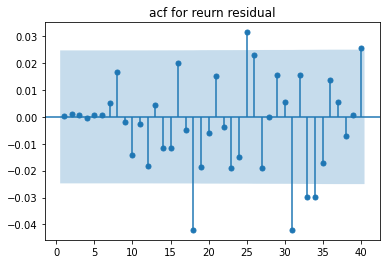

In [36]:
sgt.plot_acf(df.res_returns,zero=False,lags=40)
plt.title('acf for reurn residual')
plt.show()

## creating returns

In [37]:
df['returns']=df.market_value.pct_change(1)*100

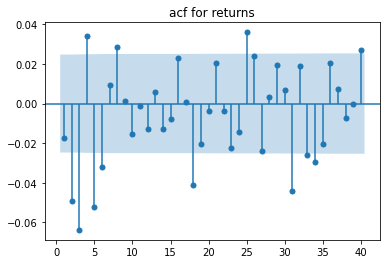

In [38]:
sgt.plot_acf(df.returns[1:],zero=False,lags=40)
plt.title('acf for returns')
plt.show()

## MA(1) model

In [39]:
model_ret_ma_1=ARMA(df.returns[1:],order=(0,1))
results_ret_ma_1=model_ret_ma_1.fit()
results_ret_ma_1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 6275
Model:                     ARMA(0, 1)   Log Likelihood               -9596.589
Method:                       css-mle   S.D. of innovations              1.117
Date:                Tue, 01 Feb 2022   AIC                          19199.178
Time:                        12:13:22   BIC                          19219.411
Sample:                    01-11-1994   HQIC                         19206.189
                         - 01-29-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.014      1.376      0.169      -0.008       0.046
ma.L1.returns    -0.0193      0.013     -1.444      0.149      -0.045       0.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           51.8864           +0.0000j           51.8864            0.0000
-----------------------------------------------------------------------------
"""